In [1]:
import pandas as pd
from typing import Optional, List, Tuple
from dotenv import load_dotenv

load_dotenv()
pd.set_option("display.max_colwidth", None)

In [2]:
import datasets

ds = datasets.load_dataset("clarin-pl/poquad", split="validation")

In [3]:
from tqdm.notebook import tqdm
from langchain.docstore.document import Document as LangchainDocument

unique_contexts = set((row['context'], row['title']) for row in ds)

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc[0], metadata={"title": doc[1]}) for doc in tqdm(unique_contexts)
]

  0%|          | 0/1449 [00:00<?, ?it/s]

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100, 
    add_start_index=True,
    strip_whitespace=True,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

In [5]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter.
print(f"Model's maximum sequence length: {SentenceTransformer('sdadas/mmlw-retrieval-roberta-large').max_seq_length}")

Model's maximum sequence length: 512


In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sdadas/mmlw-retrieval-roberta-large")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

  0%|          | 0/1964 [00:00<?, ?it/s]

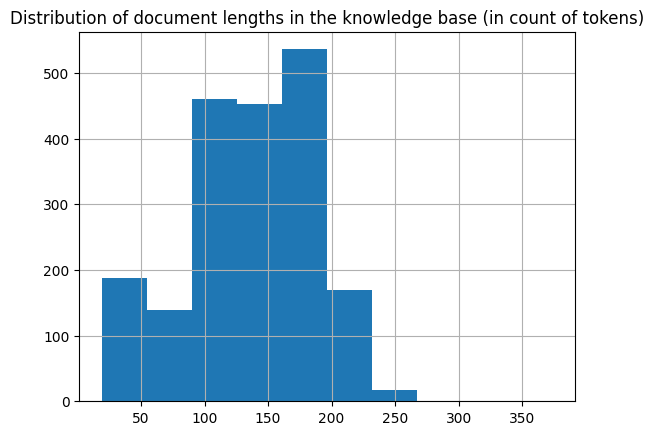

In [7]:
import matplotlib.pyplot as plt

fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [8]:
EMBEDDING_MODEL_NAME = "sdadas/mmlw-retrieval-roberta-large"

def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

  0%|          | 0/2603 [00:00<?, ?it/s]

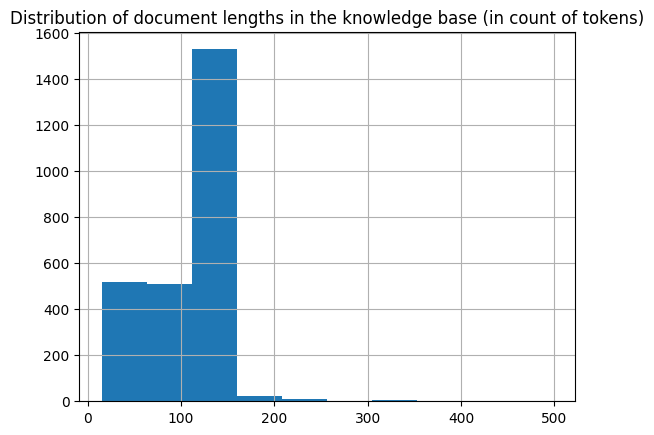

In [9]:
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [10]:
from langchain.vectorstores import Qdrant
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "mps"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

collection_name = f"poquad_{EMBEDDING_MODEL_NAME.replace('/', '_')}"

KNOWLEDGE_VECTOR_DATABASE = None

with tqdm(total=len(docs_processed), desc="Ingesting documents") as pbar:
    for d in docs_processed:
        if KNOWLEDGE_VECTOR_DATABASE:
            KNOWLEDGE_VECTOR_DATABASE.add_documents([d])
        else:
            KNOWLEDGE_VECTOR_DATABASE = Qdrant.from_documents(
                [d], 
                embedding_model,    
                url="http://localhost:6333",
                prefer_grpc=True, 
                collection_name=collection_name
            )
        pbar.update(1)  

Ingesting documents:   0%|          | 0/2603 [00:00<?, ?it/s]